<a href="https://colab.research.google.com/github/LeticiaVieirg/crack_thermal_detection/blob/main/Train_Metal_Defects_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DCGAN - Surface Defect Image Generation

1. Import necessary libraries

In [ ]:
import os
import random
import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import models, layers, Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from keras.saving import register_keras_serializable
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import (Input, Reshape, Dropout, Dense, Flatten, BatchNormalization,
                                    Activation, LeakyReLU, ReLU, PReLU, Conv2D, Conv2DTranspose, RandomRotation)
warnings.filterwarnings('ignore')

In [ ]:
# Parameters
IMG_SIZE = 256  # Original image size: [200, 200, 3]
N_CHANNELS = 3
GEN_INPUT_SIZE = 100   # size of a vector given as input to the generator
BATCH_SIZE = 32

2. Install dependences


In [ ]:
# Instalar o PyTorch
!pip install torch torchvision

# Instalar o Segment Anything Model (SAM)
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Instalar bibliotecas adicionais
!pip install opencv-python matplotlib

# Conectar ao Google Drive para carregar o dataset
from google.colab import drive
drive.mount('/content/drive')

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-tf3e4a8l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-tf3e4a8l
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-u6r5ers3
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-u6r5ers3
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


3. Carregar o Dataset e Configurar o SAM


In [ ]:
# Defina o modelo e o caminho do checkpoint
model_type = "vit_b"  # Escolha entre "vit_h", "vit_l", "vit_b"
checkpoint_path = "/content/drive/MyDrive/SAM/sam_vit_b_01ec64.pth"

# Carregue o modelo SAM
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
# Carregar o modelo SAM
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
predictor = SamPredictor(sam)

# Caminho para o dataset (substitua pelo caminho correto)
DATASET_PATH = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/TrainCrazing"
OUTPUT_PATH = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented"

# Criar a pasta de saída, se não existir
os.makedirs(OUTPUT_PATH, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
def segment_and_save(image_path, output_path, points=None, labels=None):

    # Carregar a imagem
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Configurar a imagem no preditor
    predictor.set_image(image_rgb)

    # Previsão com ou sem pontos
    if points and labels:
        masks, scores, _ = predictor.predict(
            point_coords=np.array(points),
            point_labels=np.array(labels),
            multimask_output=True
        )
    else:
        masks, scores, _ = predictor.predict(multimask_output=True)

    # Salvar as máscaras segmentadas
    for i, mask in enumerate(masks):
        mask_path = os.path.join(
            output_path,
            f"{os.path.basename(image_path).split('.')[0]}_mask_{i+1}.png"
        )
        cv2.imwrite(mask_path, (mask * 255).astype(np.uint8))
        print(f"Máscara salva em: {mask_path}")



In [ ]:
# Loop para processar todas as imagens do dataset
for image_name in os.listdir(DATASET_PATH):
    image_path = os.path.join(DATASET_PATH, image_name)

    # Verificar se é uma imagem válida
    if not image_name.lower().endswith(('.png', '.bmp', '.jpg', '.jpeg')):
        continue

    # Segmentar e salvar as máscaras
    print(f"Processando: {image_name}")
    segment_and_save(image_path, OUTPUT_PATH)


Processando: Cr_4.bmp
Máscara salva em: /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_4_mask_1.png
Máscara salva em: /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_4_mask_2.png
Máscara salva em: /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_4_mask_3.png
Processando: Cr_3.bmp
Máscara salva em: /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_3_mask_1.png
Máscara salva em: /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_3_mask_2.png
Máscara salva em: /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_3_mask_3.png
Processando: Cr_2.bmp
Máscara salva em: /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_2_mask_1.png
Máscara salva em: /conte

4. Plotting images

ERRO ao carregar /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_20.bmp
ERRO ao carregar /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_14.bmp
ERRO ao carregar /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_5.bmp
ERRO ao carregar /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_2.bmp
ERRO ao carregar /content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented/Cr_254.bmp


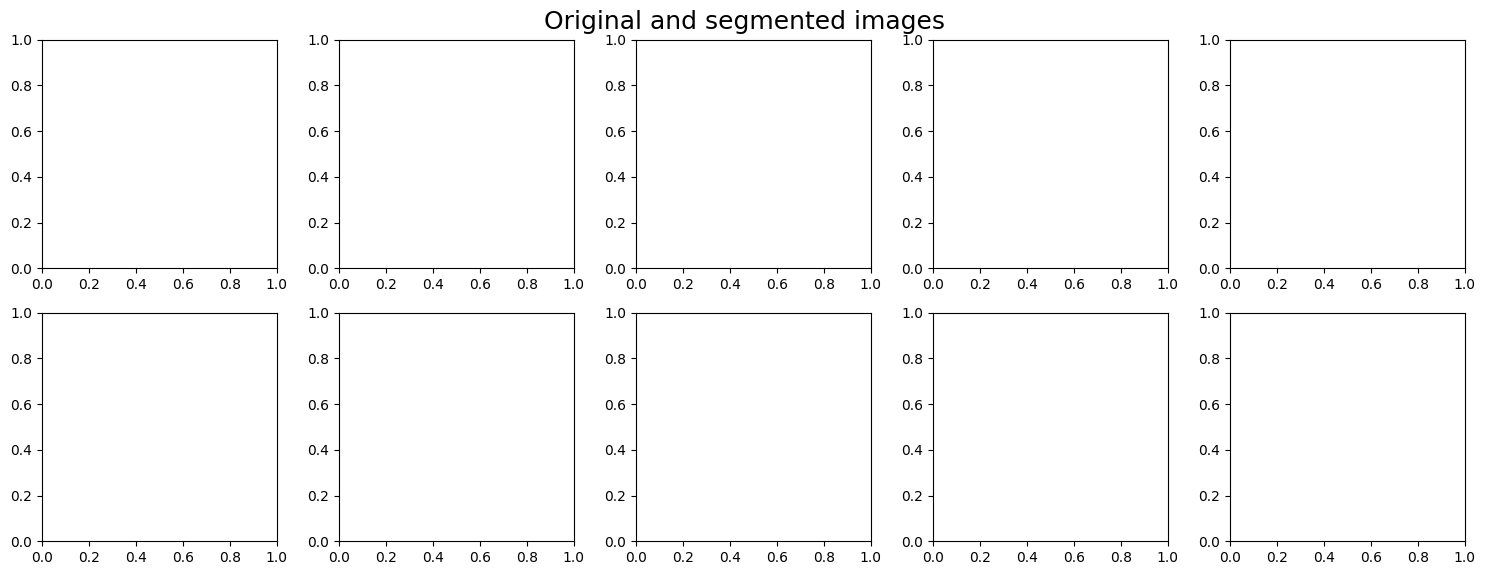

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Definir diretórios
DATASET_PATH = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/TrainCrazing"
MASKS_PATH = "/content/drive/Shareddrives/Letícia Vieira Gonçalves - Pesquisa/Metal_Dataset/metal_segmented"

# Selecionar 5 imagens aleatórias do dataset
#all_images = [img for img in os.listdir(DATASET_PATH) if img.lower().endswith(('.png','.bmp', '.jpg', '.jpeg'))]
#selected_images = random.sample(all_images, min(5, len(all_images)))  # Garante que não selecione mais do que existe
selected_images={
    "Cr_254.bmp",
    "Cr_2.bmp",
    "Cr_5.bmp",
    "Cr_14.bmp",
    "Cr_20.bmp"
}

# Criar a figura para visualização
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Original and segmented images', fontsize=18, y=0.95)

for i, image_name in enumerate(selected_images):
    image_path = os.path.join(DATASET_PATH, image_name)
    mask_path = os.path.join(MASKS_PATH, image_name)  # Supondo que as máscaras tenham o mesmo nome das imagens

    # Carregar a imagem original
    image = cv2.imread(image_path)
    if image is None:
        print(f"ERRO ao carregar {image_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Carregar a máscara segmentada
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"ERRO ao carregar {mask_path}")
        continue

    # Exibir imagem original
    axs[0, i].imshow(image)
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Original {i+1}")

    # Exibir máscara segmentada
    axs[1, i].imshow(mask, cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Mask {i+1}")

plt.tight_layout()
plt.show()


5. Automatic mask generation

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
import os
import cv2
import numpy as np

def calculate_iou(y_true, y_pred):
    """
    Calcula o IoU (Intersection over Union) entre a máscara ground truth (y_true)
    e a máscara predita (y_pred).

    Args:
        y_true (ndarray): Máscara ground truth binária.
        y_pred (ndarray): Máscara predita binária.

    Returns:
        float: Valor do IoU.
    """
    # Converte as predições para binário (threshold = 0.5)
    y_pred = (y_pred > 0.5).astype(np.uint8)

    # Calcula a interseção e união
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    # Evita divisão por zero
    if union == 0:
        return 0.0
    else:
        return intersection / union

def mean_iou(mask_gt, masks_pred):
    """
    Calcula o IoU médio entre as máscaras ground truth e as máscaras preditivas.

    Args:
        mask_gt (ndarray): Máscara ground truth binária.
        masks_pred (list of ndarray): Lista de máscaras preditivas binárias.

    Returns:
        float: Valor do IoU médio.
    """
    iou_scores = [calculate_iou(mask_gt, mask_pred) for mask_pred in masks_pred]
    return np.mean(iou_scores)

# Diretórios de imagens e máscaras
DATASET_PATH = "/content/drive/MyDrive/dataset/dataset/Positive"
MASKS_PATH = "/content/drive/MyDrive/dataset/dataset/segmented_dataset"


# Inicializar a lista de resultados e variáveis para IoU
all_iou = []

all_images = [img for img in os.listdir(DATASET_PATH) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

for image_name in all_images:
    image_path = os.path.join(DATASET_PATH, image_name)
    mask_path = os.path.join(MASKS_PATH, image_name)  # Supondo que as máscaras tenham o mesmo nome das imagens

    # Carregar a imagem original (não usada aqui, mas pode ser útil para depuração)
    image = cv2.imread(image_path)
    if image is None:
        print(f"ERRO ao carregar {image_path}")
        continue

    # Carregar a máscara ground truth
    mask_gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_gt is None:
        print(f"ERRO ao carregar {mask_path}")
        continue
    mask_gt = (mask_gt > 127).astype(np.uint8)  # Certifica que é binária

    # Carregar a máscara preditiva (Aqui você já tem a máscara predita gerada, por exemplo, em `masks_pred`)
    # Aqui assumimos que você já tem as máscaras preditivas de alguma forma, por exemplo:
    masks_pred = [mask_gt]  # Isso é só um exemplo. Substitua com suas máscaras preditivas.

    # Calcular o IoU médio para a imagem
    iou_value = mean_iou(mask_gt, masks_pred)
    all_iou.append(iou_value)

# Calcular e exibir o IoU médio geral
mean_iou_value = np.mean(all_iou)
print(f"IoU médio geral: {mean_iou_value:.4f}")

IoU médio geral: 1.0000
